# Imports #

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
!pip install mtcnn
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from sklearn.manifold import TSNE
from PIL import Image
from skimage import exposure
from mtcnn import MTCNN
from collections import defaultdict
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
import re
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import contingency_matrix
import shutil
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [89]:
current_path = '/content/drive/MyDrive/Colab Notebooks/FacialClustering'

#Utils#

In [90]:
def remove_suffix(file_name):
  #subject03 (1).rightlight.png
  # Use regex to match patterns like "(number)" in the file name
  match = re.search(r'\s*\(\d+\)', file_name)
  if match:
      # If there's a match, remove the matched pattern from the file name
      original_name = re.sub(r'\s*\(\d+\)', '', file_name).strip()
  else:
      # If no match found, use the original file name
      original_name = file_name
  return original_name

def calculate_contingency_table(labels, clusters):
    unique_labels = np.unique(labels)
    unique_clusters = np.unique(clusters)
    contingency_table = np.zeros((len(unique_labels), len(unique_clusters)))

    for i in range(len(labels)):
        label_idx = np.where(unique_labels == labels[i])[0][0]
        cluster_idx = np.where(unique_clusters == clusters[i])[0][0]
        contingency_table[label_idx, cluster_idx] += 1

    return contingency_table

def calculate_purity(contingency_table):
    max_counts = np.max(contingency_table, axis=0)
    total = np.sum(contingency_table)
    purity = np.sum(max_counts) / total
    return purity

def calculate_rand_index(contingency_table):
    n = np.sum(contingency_table)  # Total number of data points
    # Calculate true positives
    true_positives = np.sum(np.square(contingency_table)) - np.sum(contingency_table ** 2)
    # Calculate false positives and false negatives
    false_positives = np.sum(np.sum(np.square(contingency_table), axis=1)) - true_positives
    false_negatives = np.sum(np.sum(np.square(contingency_table), axis=0)) - true_positives
    # Calculate total pairs
    total_pairs = n * (n - 1) / 2
    # Calculate Rand index
    rand_index = (true_positives + np.sum(false_positives) + np.sum(false_negatives)) / total_pairs
    return rand_index

def reform_labels(labels):
  subject_numbers = [int(re.findall(r'\d+', label)[0]) for label in labels]
  return subject_numbers

# PreProcess #

## Normalization, Resize ##

In [ ]:
def load_and_preprocess_images(dataset_path, save_path, target_size=(224, 224)):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    preprocessed_images = []
    labels = []

    for file_name in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, file_name)
        if os.path.isfile(file_path):
            image = Image.open(file_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')

            # Crop and resize the image
            image = image.resize(target_size)
            print(image)

            # Convert to numpy array
            image_array = np.array(image)

            # Normalize the pixel values to the range [0, 1]
            image_array = image_array / 255.0

            # Save the preprocessed image
            save_file_path = os.path.join(save_path, file_name + '.png')
            Image.fromarray((image_array * 255).astype(np.uint8)).save(save_file_path)

            preprocessed_images.append(save_file_path)
            labels.append(file_name)

    return preprocessed_images, labels

# Define the dataset path and save path
dataset_path = f'{current_path}/dataset/dataset'
save_path = f'{current_path}/dataset/Normalized.Resized.Dataset'

# Perform loading and preprocessing
preprocessed_images, labels = load_and_preprocess_images(dataset_path, save_path)

print("Preprocessing complete.")


<PIL.Image.Image image mode=RGB size=224x224 at 0x7FE3A41B4CA0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FE3A41B7C10>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FE39C1C9420>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FE38FBD5AE0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FE457B0D750>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FE39C1C9420>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FE38FBD5AE0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FE457B0D750>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FE38F7548B0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FE39C1C9420>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FE38F7548B0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FE38FBD5AE0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FE393F5B970>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FE39C1C9420>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FE393F5B970>
<PIL.Image.Image image mode=RGB size=224

## Normalization, Resize, Face Detection ##

In [ ]:
def load_and_preprocess_images(dataset_path, save_path, target_size=(224, 224)):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    preprocessed_images = []
    labels = []

    detector = MTCNN()

    for file_name in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, file_name)
        if os.path.isfile(file_path):
            image = Image.open(file_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')

            faces = detector.detect_faces(np.array(image))
            print(faces)

            if len(faces) != 1:
                continue

            x, y, w, h = faces[0]['box']
            # Crop and resize the face region
            image = image.crop((x, y, x + w, y + h)).resize(target_size)

            # Convert to numpy array
            image_array = np.array(image)

            # Normalize the pixel values to the range [0, 1]
            image_array = image_array / 255.0

            # Save the preprocessed image
            save_file_path = os.path.join(save_path, file_name + '.png')
            Image.fromarray((image_array * 255).astype(np.uint8)).save(save_file_path)

            preprocessed_images.append(save_file_path)
            labels.append(file_name)

    return preprocessed_images, labels

# Define the dataset path and save path
dataset_path = f'{current_path}/dataset/dataset'
save_path = f'{current_path}/dataset/Normalized.Resized.FaceDetected.Dataset'

# Perform loading and preprocessing
preprocessed_images, labels = load_and_preprocess_images(dataset_path, save_path)

print("Preprocessing complete.")


1/1 [==============================] - 0s 176ms/step
[{'box': [119, 83, 111, 138], 'confidence': 0.9999492168426514, 'keypoints': {'left_eye': (151, 134), 'right_eye': (203, 134), 'nose': (178, 166), 'mouth_left': (157, 191), 'mouth_right': (200, 191)}}]
1/1 [==============================] - 0s 33ms/step
[{'box': [103, 80, 112, 143], 'confidence': 0.9999380111694336, 'keypoints': {'left_eye': (137, 136), 'right_eye': (188, 135), 'nose': (163, 172), 'mouth_left': (138, 187), 'mouth_right': (188, 187)}}]
1/1 [==============================] - 0s 37ms/step
[{'box': [122, 64, 119, 154], 'confidence': 0.9999986886978149, 'keypoints': {'left_eye': (153, 118), 'right_eye': (207, 122), 'nose': (177, 151), 'mouth_left': (155, 175), 'mouth_right': (205, 178)}}]
1/1 [==============================] - 0s 33ms/step
[{'box': [119, 61, 125, 164], 'confidence': 0.9999946355819702, 'keypoints': {'left_eye': (155, 117), 'right_eye': (210, 118), 'nose': (185, 144), 'mouth_left': (161, 182), 'mouth_right

## Normalization, Face Detection, Crop & Resize, Data Balancing ##

In [ ]:
def load_and_preprocess_images(dataset_path, save_path, target_size=(224, 224)):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    preprocessed_images = []
    labels = []

    detector = MTCNN()
    label_count = defaultdict(int)

    for file_name in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, file_name)
        if os.path.isfile(file_path):
            image = Image.open(file_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')

            faces = detector.detect_faces(np.array(image))
            print(faces)
            if len(faces) != 1:
                continue

            x, y, w, h = faces[0]['box']
            # Crop and resize the face region
            image = image.crop((x, y, x + w, y + h)).resize(target_size)

            # Convert to numpy array
            image_array = np.array(image)

            # Normalize the pixel values to the range [0, 1]
            image_array = image_array / 255.0

            # Save the preprocessed image
            save_file_path = os.path.join(save_path, file_name + '.png')
            Image.fromarray((image_array * 255).astype(np.uint8)).save(save_file_path)

            preprocessed_images.append(save_file_path)
            labels.append(file_name)
            label_count[file_name] += 1

    # Ensure data balancing
    min_count = min(label_count.values())
    balanced_preprocessed_images = []
    balanced_labels = []
    for img_path, label in zip(preprocessed_images, labels):
        if label_count[label] > min_count:
            balanced_preprocessed_images.append(img_path)
            balanced_labels.append(label)
            label_count[label] -= 1

    return balanced_preprocessed_images, balanced_labels

# Define the dataset path and save path
dataset_path = f'{current_path}/dataset/dataset'
save_path = f'{current_path}/dataset/Normalized.Resized.FaceDetected.DataBalanced.Dataset'

# Perform loading and preprocessing
preprocessed_images, labels = load_and_preprocess_images(dataset_path, save_path)

print("Preprocessing complete.")


1/1 [==============================] - 0s 37ms/step
Preprocessing complete.


## Normalization, Face Detection, Crop, Data Balancing ##

In [ ]:
def load_and_preprocess_images(dataset_path, save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    preprocessed_images = []
    labels = []

    detector = MTCNN()
    label_count = defaultdict(int)

    for file_name in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, file_name)
        if os.path.isfile(file_path):
            image = Image.open(file_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')

            faces = detector.detect_faces(np.array(image))
            if len(faces) != 1:
                continue

            x, y, w, h = faces[0]['box']
            # Crop the face region
            face_image = image.crop((x, y, x + w, y + h))

            # Convert to numpy array
            face_array = np.array(face_image)

            # Normalize the pixel values to the range [0, 1]
            face_array = face_array / 255.0

            # Save the preprocessed image
            save_file_path = os.path.join(save_path, file_name + '.png')
            Image.fromarray((face_array * 255).astype(np.uint8)).save(save_file_path)

            preprocessed_images.append(save_file_path)
            labels.append(file_name)
            label_count[file_name] += 1

    # Ensure data balancing
    min_count = min(label_count.values())
    balanced_preprocessed_images = []
    balanced_labels = []
    for img_path, label in zip(preprocessed_images, labels):
        if label_count[label] > min_count:
            balanced_preprocessed_images.append(img_path)
            balanced_labels.append(label)
            label_count[label] -= 1

    return balanced_preprocessed_images, balanced_labels

# Define the dataset path and save path
dataset_path = f'{current_path}/dataset/dataset'
save_path = f'{current_path}/dataset/Normalized.FaceDetected.DataBalanced.Dataset'

# Perform loading and preprocessing
preprocessed_images, labels = load_and_preprocess_images(dataset_path, save_path)

print("Preprocessing complete.")


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 30ms/step
Preprocessing complete.


## Normalization, Face Detection, Crop, Data Balancing ##

In [ ]:
def load_and_preprocess_images(dataset_path, save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    preprocessed_images = []
    labels = []

    detector = MTCNN()

    for file_name in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, file_name)
        if os.path.isfile(file_path):
            image = Image.open(file_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')

            faces = detector.detect_faces(np.array(image))
            if len(faces) != 1:
                continue

            x, y, w, h = faces[0]['box']
            # Crop the face region
            face_image = image.crop((x, y, x + w, y + h))

            # Convert to numpy array
            face_array = np.array(face_image)

            # Normalize the pixel values to the range [0, 1]
            face_array = face_array / 255.0

            # Save the preprocessed image
            save_file_path = os.path.join(save_path, file_name + '.png')
            Image.fromarray((face_array * 255).astype(np.uint8)).save(save_file_path)

            preprocessed_images.append(save_file_path)
            labels.append(file_name)

    return preprocessed_images, labels

# Define the dataset path and save path
dataset_path = f'{current_path}/dataset/dataset'
save_path = f'{current_path}/dataset/Normalized.FaceDetected.Dataset'

# Perform loading and preprocessing
preprocessed_images, labels = load_and_preprocess_images(dataset_path, save_path)

print("Preprocessing complete.")


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 27ms/step
Preprocessing complete.


# Load Dataset #

## Default dataset ##

In [106]:
data_path = f'{current_path}/dataset/dataset'

## Normalized, Resized dataset ##

In [ ]:
data_path = f'{current_path}/dataset/Normalized.Resized.Dataset'

## Normalized, Resized, FaceDetected dataset ##

In [ ]:
data_path = f'{current_path}/dataset/Normalized.Resized.FaceDetected.Dataset'

## Normalized, Resized, FaceDetected, DataBalanced ##

In [ ]:
data_path = f'{current_path}/dataset/Normalized.Resized.FaceDetected.DataBalanced.Dataset'

Normalized.Resized.FaceDetected.DataBalanced.Dataset


## Normalized, FaceDetected, DataBalanced ##

In [91]:
data_path = f'{current_path}/dataset/Normalized.FaceDetected.DataBalanced.Dataset'

## Normalized, FaceDetected ##

In [114]:
data_path = f'{current_path}/dataset/Normalized.FaceDetected.Dataset'

# Feature Extraction Methods #

## Extract labels and image path ##

In [118]:
image_files = []
labels = []

for file_name in os.listdir(data_path):
    file_name = remove_suffix(file_name)

    if os.path.isfile(os.path.join(data_path, file_name)):
        image_files.append(os.path.join(data_path, file_name))
        labels.append(file_name)

## NP Feature Extraction ##

In [ ]:
# Feature Extraction
def extract_feature(image):
    # Apply any preprocessing if needed
    # Extract features using a pre-trained CNN or any other method
    # Placeholder function, replace with actual feature extraction
    feature_vector = np.random.rand(1000)  # Random feature vector, replace with actual features
    return feature_vector

feature_vectors = []
for image_file in image_files:
    image = cv2.imread(image_file)
    feature_vector = extract_feature(image)
    feature_vectors.append(feature_vector)

print('number of labels', len(labels))

# Saving Feature Vectors (optional)
feature_type = os.path.basename(data_path)
np.save(f'{current_path}/{feature_type}.feature_vectors.npy', feature_vectors)
np.save(f'{current_path}/{feature_type}.labels.npy', labels)

number of labels 175


## VGG16 Feature Extraction ##

In [ ]:
# Feature Extraction using a pre-trained CNN (VGG16)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_feature(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    features = vgg16.predict(img_array)
    return features.flatten()

feature_vectors = []
for image_file in image_files:
    feature_vector = extract_feature(image_file)
    feature_vectors.append(feature_vector)

# Saving Feature Vectors
feature_type = os.path.basename(data_path)
np.save(f'{current_path}/{feature_type}.feature_vectors.npy', feature_vectors)
np.save(f'{current_path}/{feature_type}.labels.npy', labels)

subject03 (1).rightlight subject03.rightlight
subject03 (1).happy subject03.happy
subject01.wink subject01.wink
subject01.sad subject01.sad
subject03 (1).normal subject03.normal
subject04.noglasses subject04.noglasses
subject04.leftlight subject04.leftlight
subject01.glasses subject01.glasses
subject01.rightlight subject01.rightlight
subject03.rightlight subject03.rightlight
subject01.surprised subject01.surprised
subject02 (1).wink subject02.wink
subject01.noglasses subject01.noglasses
subject05.centerlight subject05.centerlight
subject04.rightlight subject04.rightlight
subject04.wink subject04.wink
subject03.normal subject03.normal
subject05.glasses subject05.glasses
subject01.happy subject01.happy
subject02.wink subject02.wink
subject03 (1).sad subject03.sad
subject03.wink subject03.wink
subject04.sleepy subject04.sleepy
subject02.leftlight subject02.leftlight
subject01.sleepy subject01.sleepy
subject02.normal subject02.normal
subject03.sleepy subject03.sleepy
subject01.centerlight 

KeyboardInterrupt: 

## RESNET Feature Extraction ##

In [111]:
# Load the pre-trained ResNet50 model without the top classification layer
resnet50 = ResNet50(weights='imagenet', include_top=False)
# resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to extract features from an image using the ResNet50 model
def extract_feature(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Preprocess input according to ResNet50 requirements
    features = resnet50.predict(img_array)
    return features.flatten()

# Assuming you have a list of image file paths in 'image_files' and corresponding labels in 'labels'
feature_vectors = []
for image_file in image_files:
    feature_vector = extract_feature(image_file)
    feature_vectors.append(feature_vector)

# Saving Feature Vectors
feature_type = os.path.basename(data_path)
np.save(f'{current_path}/{feature_type}.feature_vectors.npy', feature_vectors)
np.save(f'{current_path}/{feature_type}.labels.npy', labels)


1/1 [==============================] - 0s 204ms/step


# Load Features & Labels #

## Default features ##

In [119]:
feature_type = 'dataset'
feature_vectors = np.load(f'{current_path}/{feature_type}.feature_vectors.npy')
labels = np.load(f'{current_path}/{feature_type}.labels.npy')

## Normalized.Resized features ##

In [ ]:
feature_type = 'Normalized.Resized.Dataset'
feature_vectors = np.load(f'{current_path}/{feature_type}.feature_vectors.npy')
labels = np.load(f'{current_path}/{feature_type}.labels.npy')

['subject03 (1).rightlight.png' 'subject03 (1).happy.png'
 'subject01.wink.png' 'subject01.sad.png' 'subject03 (1).normal.png'
 'subject04.noglasses.png' 'subject04.leftlight.png'
 'subject01.glasses.png' 'subject01.rightlight.png'
 'subject03.rightlight.png' 'subject01.surprised.png'
 'subject02 (1).wink.png' 'subject01.noglasses.png'
 'subject05.centerlight.png' 'subject04.rightlight.png'
 'subject04.wink.png' 'subject03.normal.png' 'subject05.glasses.png'
 'subject01.happy.png' 'subject02.wink.png' 'subject03 (1).sad.png'
 'subject03.wink.png' 'subject04.sleepy.png' 'subject02.leftlight.png'
 'subject01.sleepy.png' 'subject02.normal.png' 'subject03.sleepy.png'
 'subject01.centerlight.png' 'subject02.glasses.png'
 'subject02.centerlight.png' 'subject02 (1).surprised.png'
 'subject03 (1).leftlight.png' 'subject02.rightlight.png'
 'subject04.happy.png' 'subject04.sad.png' 'subject04.normal.png'
 'subject02.sad.png' 'subject03.surprised.png' 'subject05.leftlight.png'
 'subject03 (1).cen

## Normalized.Resized.FaceDetected features ##

In [ ]:
feature_type = 'Normalized.Resized.FaceDetected.Dataset'
feature_vectors = np.load(f'{current_path}/{feature_type}.feature_vectors.npy')
labels = np.load(f'{current_path}/{feature_type}.labels.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/FacialClustering/Normalized.Resized.FaceDetected.feature_vectors.npy'

## Normalized.Resized.FaceDetected.DataBalanced features ##

In [ ]:
feature_type = 'Normalized.Resized.FaceDetected.DataBalanced.Dataset'
feature_vectors = np.load(f'{current_path}/{feature_type}.feature_vectors.npy')
labels = np.load(f'{current_path}/{feature_type}.labels.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/FacialClustering/Normalized.Resized.FaceDetected.DataBalanced.feature_vectors.npy'

## Normalized.FaceDetected.DataBalanced features ##

In [ ]:
feature_type = 'Normalized.FaceDetected.DataBalanced.Dataset'
feature_vectors = np.load(f'{current_path}/{feature_type}.feature_vectors.npy')
labels = np.load(f'{current_path}/{feature_type}.labels.npy')

## Normalized.FaceDetected features ##

In [115]:
feature_type = 'Normalized.FaceDetected.Dataset'
feature_vectors = np.load(f'{current_path}/{feature_type}.feature_vectors.npy')
labels = np.load(f'{current_path}/{feature_type}.labels.npy')

# Dimension Reduction Methods #

## PCA Dimension Reduction ##

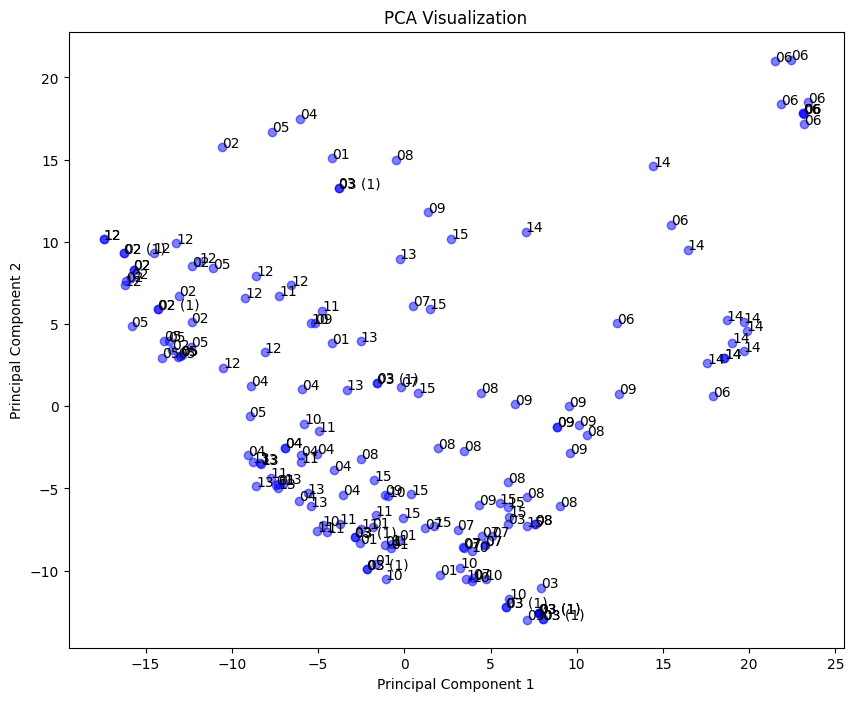

In [ ]:
# Dimension Reduction
pca = PCA(n_components=175)  # You can choose the number of components based on your dataset
reduced_features = pca.fit_transform(feature_vectors)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c='blue', alpha=0.5)
for i in range(len(labels)):
    plt.text(reduced_features[i, 0], reduced_features[i, 1], labels[i].split('.')[0].split('subject')[1])
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## t-SNE Dimension Reduction ##

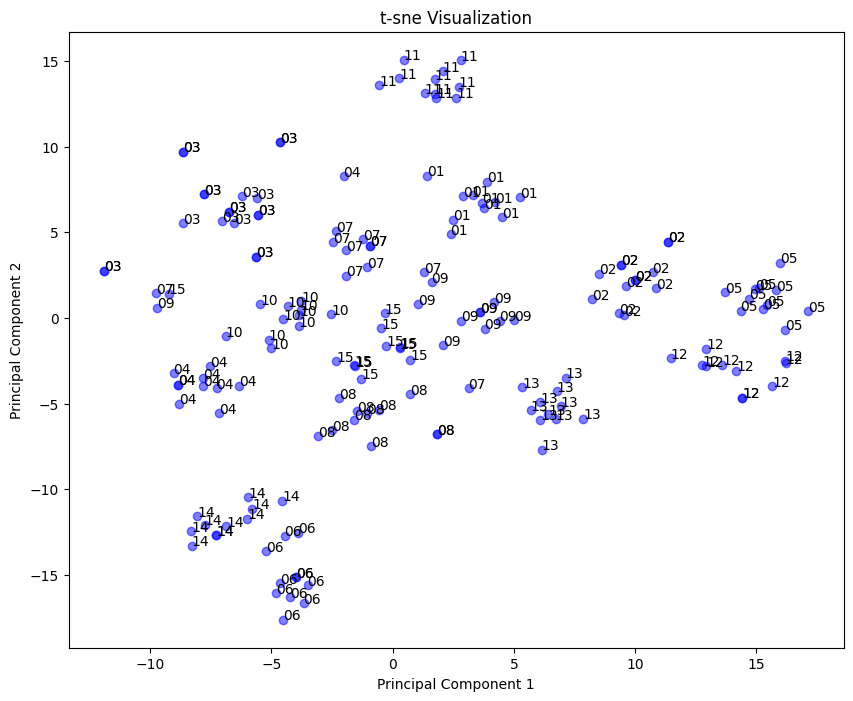

In [120]:
# Dimension Reduction using t-SNE
# Convert feature_vectors to a NumPy array
feature_vectors_array = np.array(feature_vectors)

# Dimension Reduction using t-SNE
tsne = TSNE(n_components=2)
reduced_features = tsne.fit_transform(feature_vectors_array)
# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c='blue', alpha=0.5)
for i in range(len(labels)):
    plt.text(reduced_features[i, 0], reduced_features[i, 1], labels[i].split('.')[0].split('subject')[1])
plt.title('t-sne Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Clustering Methods #

## Kmeans Clustering  ##

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity: 0.8
Rand Index: 0.2174055829228243


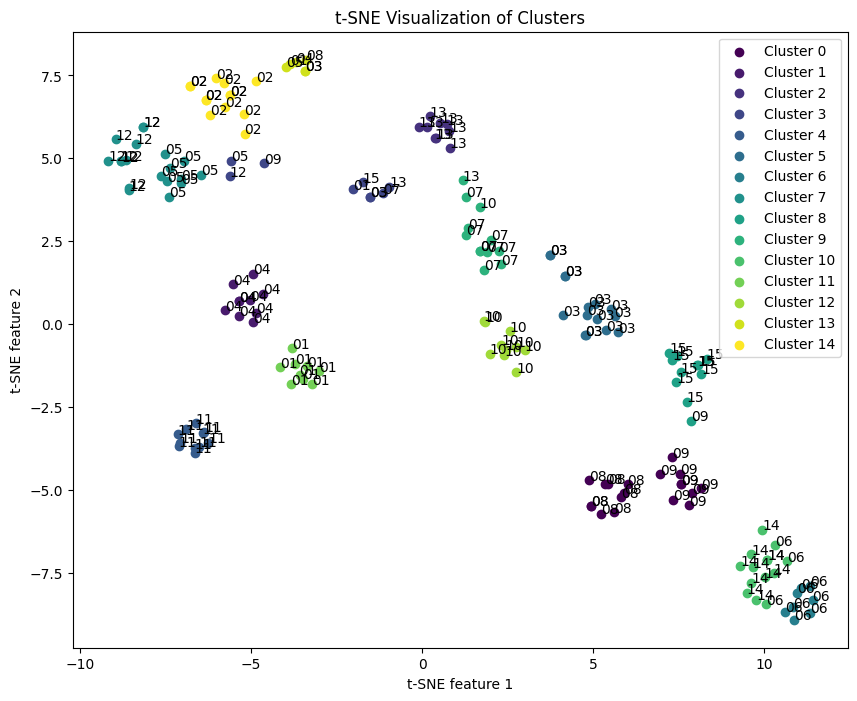

In [108]:
clustering_method = 'kmeans'
# Clustering
kmeans = KMeans(n_clusters=15)  # You can choose the number of clusters based on your dataset
clusters = kmeans.fit_predict(reduced_features)

# Visualization
tsne = TSNE(n_components=2)
embedded_features = tsne.fit_transform(reduced_features)

# Get unique cluster labels
unique_clusters = np.unique(clusters)

# Define colors for each cluster
cluster_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Plotting
plt.figure(figsize=(10, 8))
for i, cluster_label in enumerate(unique_clusters):
    cluster_indices = np.where(clusters == cluster_label)[0]
    plt.scatter(embedded_features[cluster_indices, 0], embedded_features[cluster_indices, 1], c=[cluster_colors[i]], label=f'Cluster {cluster_label}')

# Add labels
for i in range(len(embedded_features)):
    plt.text(embedded_features[i, 0], embedded_features[i, 1], labels[i].split('.')[0].split('subject')[1])

# Purity and Rand index
contingency_table = calculate_contingency_table(np.array(reform_labels(labels)), np.array(clusters))
purity = calculate_purity(contingency_table)
rand_index = calculate_rand_index(contingency_table)
print("Purity:", purity)
print("Rand Index:", rand_index)

plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()

## DBSCAN Clustering  ##

14
Purity: 0.8114285714285714
Rand Index: 0.21582922824302134


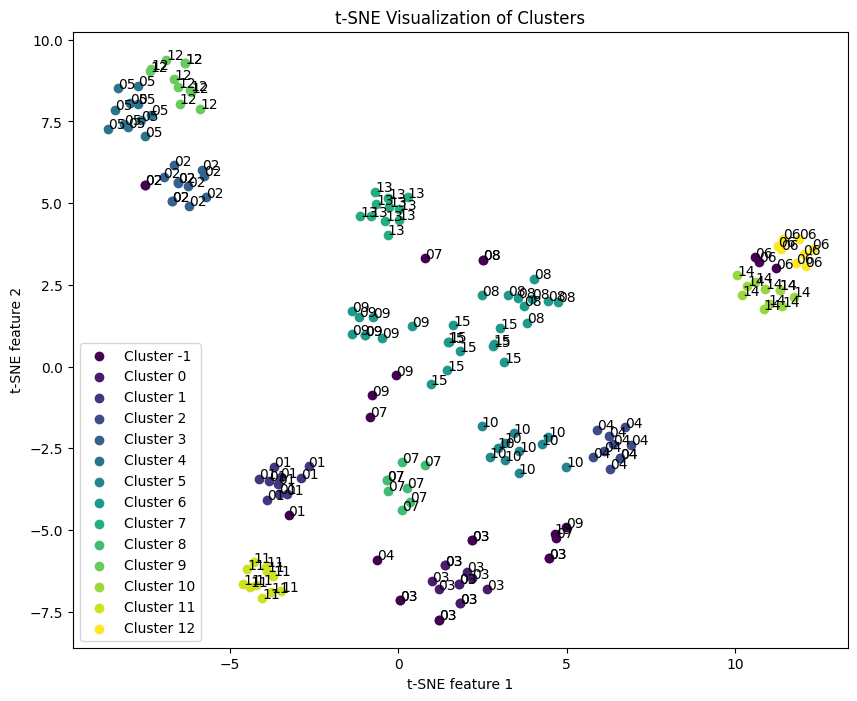

In [124]:
clustering_method = 'dbscan'
# Clustering
dbscan = DBSCAN(eps=1.8, min_samples=5)  # Adjust parameters as needed
clusters = dbscan.fit_predict(reduced_features)

# Visualization
tsne = TSNE(n_components=2)
embedded_features = tsne.fit_transform(reduced_features)

# Get unique cluster labels
unique_clusters = np.unique(clusters)
print(len(unique_clusters))

# Define colors for each cluster
cluster_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Plotting
plt.figure(figsize=(10, 8))
for i, cluster_label in enumerate(unique_clusters):
    cluster_indices = np.where(clusters == cluster_label)[0]
    plt.scatter(embedded_features[cluster_indices, 0], embedded_features[cluster_indices, 1], c=[cluster_colors[i]], label=f'Cluster {cluster_label}')

# Add labels
for i in range(len(embedded_features)):
    plt.text(embedded_features[i, 0], embedded_features[i, 1], labels[i].split('.')[0].split('subject')[1])

# Purity and Rand index
contingency_table = calculate_contingency_table(np.array(reform_labels(labels)), np.array(clusters))
purity = calculate_purity(contingency_table)
rand_index = calculate_rand_index(contingency_table)
print("Purity:", purity)
print("Rand Index:", rand_index)

plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()


## Agglomerative Clustering  ##

Purity: 0.7885714285714286
Rand Index: 0.18167487684729064


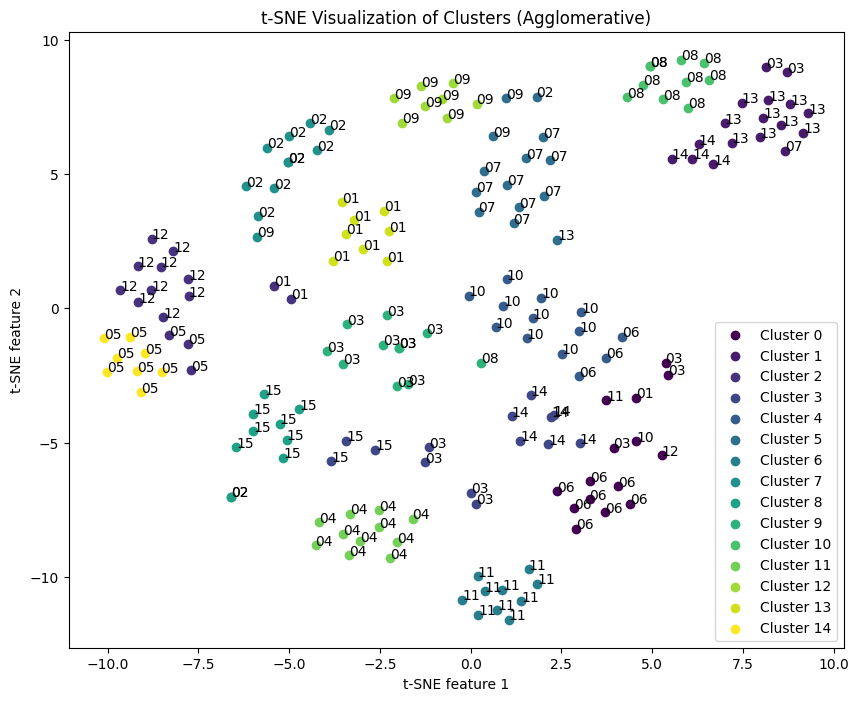

In [100]:
clustering_method = 'agglomerative'
# Clustering
agglomerative = AgglomerativeClustering(n_clusters=15)
clusters = agglomerative.fit_predict(reduced_features)

# Visualization
tsne = TSNE(n_components=2)
embedded_features = tsne.fit_transform(reduced_features)

# Get unique cluster labels
unique_clusters = np.unique(clusters)

# Define colors for each cluster
cluster_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Plotting
plt.figure(figsize=(10, 8))
for i, cluster_label in enumerate(unique_clusters):
    cluster_indices = np.where(clusters == cluster_label)[0]
    plt.scatter(embedded_features[cluster_indices, 0], embedded_features[cluster_indices, 1], c=[cluster_colors[i]], label=f'Cluster {cluster_label}')

# Add labels
for i in range(len(embedded_features)):
    plt.text(embedded_features[i, 0], embedded_features[i, 1], labels[i].split('.')[0].split('subject')[1])

# Purity and Rand index
contingency_table = calculate_contingency_table(np.array(reform_labels(labels)), np.array(clusters))
purity = calculate_purity(contingency_table)
rand_index = calculate_rand_index(contingency_table)
print("Purity:", purity)
print("Rand Index:", rand_index)

plt.title('t-SNE Visualization of Clusters (Agglomerative)')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()


## Gaussian Clustering  ##

Purity: 0.8857142857142857
Rand Index: 0.21582922824302134


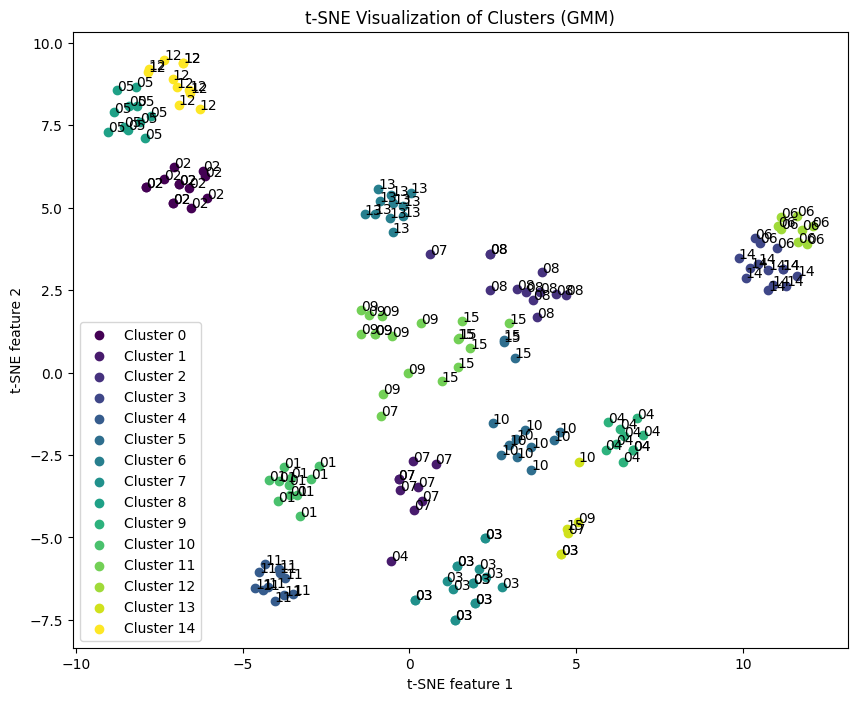

In [125]:
clustering_method = 'gaussian'
# Clustering
gmm = GaussianMixture(n_components=15)
clusters = gmm.fit_predict(reduced_features)

# Visualization
tsne = TSNE(n_components=2)
embedded_features = tsne.fit_transform(reduced_features)

# Get unique cluster labels
unique_clusters = np.unique(clusters)

# Define colors for each cluster
cluster_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Plotting
plt.figure(figsize=(10, 8))
for i, cluster_label in enumerate(unique_clusters):
    cluster_indices = np.where(clusters == cluster_label)[0]
    plt.scatter(embedded_features[cluster_indices, 0], embedded_features[cluster_indices, 1], c=[cluster_colors[i]], label=f'Cluster {cluster_label}')

# Add labels
for i in range(len(embedded_features)):
    plt.text(embedded_features[i, 0], embedded_features[i, 1], labels[i].split('.')[0].split('subject')[1])

# Purity and Rand index
contingency_table = calculate_contingency_table(np.array(reform_labels(labels)), np.array(clusters))
purity = calculate_purity(contingency_table)
print("Purity:", purity)
print("Rand Index:", rand_index)

plt.title('t-SNE Visualization of Clusters (GMM)')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()


## Spectral Clustering  ##

Purity: 0.6571428571428571
Rand Index: 0.1961247947454844


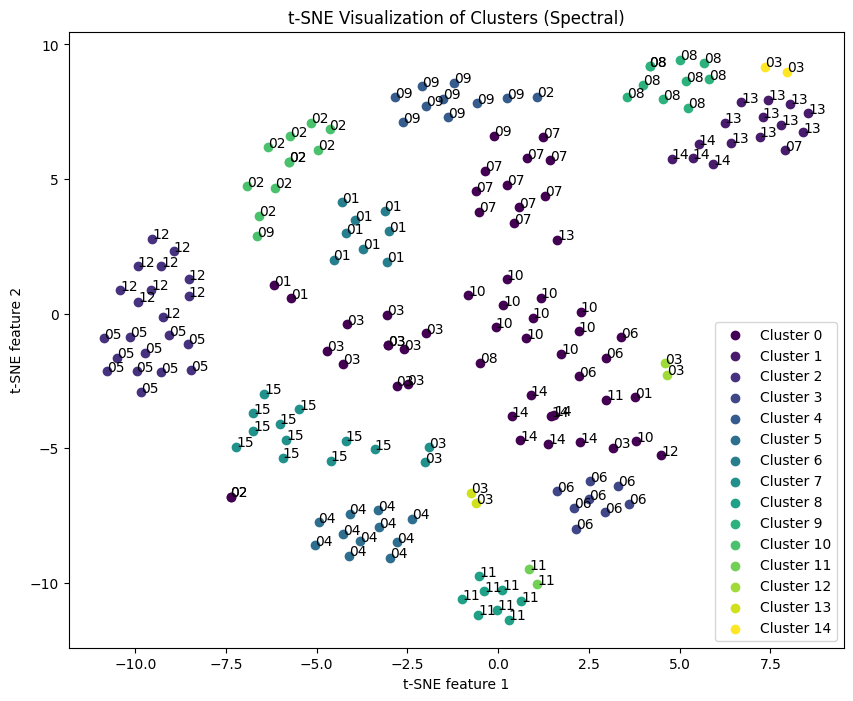

In [102]:
clustering_method = 'spectural'
# Clustering
spectral = SpectralClustering(n_clusters=15)
clusters = spectral.fit_predict(reduced_features)

# Visualization
tsne = TSNE(n_components=2)
embedded_features = tsne.fit_transform(reduced_features)

# Get unique cluster labels
unique_clusters = np.unique(clusters)

# Define colors for each cluster
cluster_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Plotting
plt.figure(figsize=(10, 8))
for i, cluster_label in enumerate(unique_clusters):
    cluster_indices = np.where(clusters == cluster_label)[0]
    plt.scatter(embedded_features[cluster_indices, 0], embedded_features[cluster_indices, 1], c=[cluster_colors[i]], label=f'Cluster {cluster_label}')

# Add labels
for i in range(len(embedded_features)):
    plt.text(embedded_features[i, 0], embedded_features[i, 1], labels[i].split('.')[0].split('subject')[1])

# Purity and Rand index
contingency_table = calculate_contingency_table(np.array(reform_labels(labels)), np.array(clusters))
purity = calculate_purity(contingency_table)
rand_index = calculate_rand_index(contingency_table)
print("Purity:", purity)
print("Rand Index:", rand_index)

plt.title('t-SNE Visualization of Clusters (Spectral)')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()


## MeanShift Clustering  ##

Purity: 0.8971428571428571
Rand Index: 0.2271264367816092


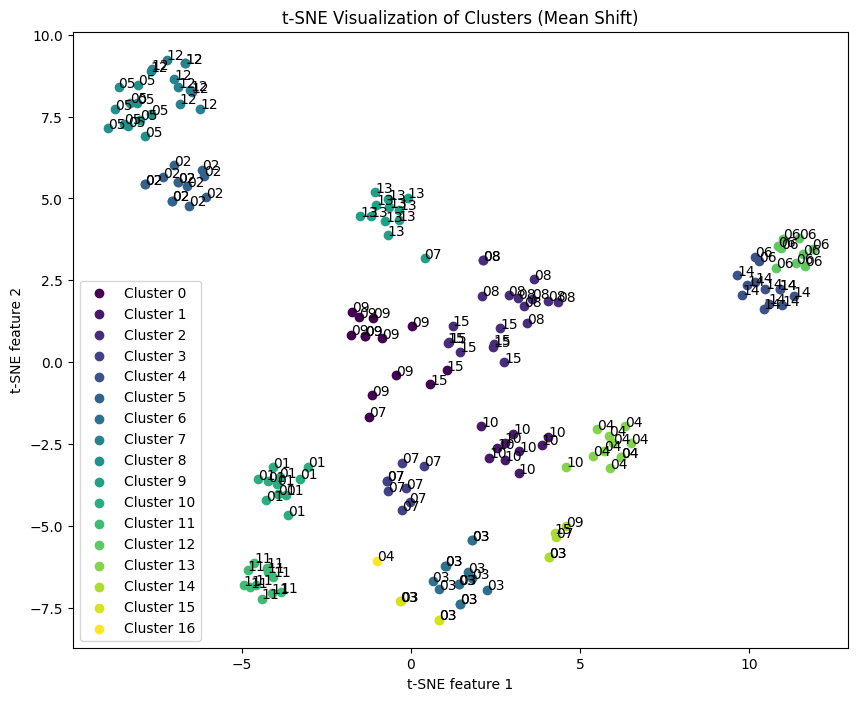

In [123]:
clustering_method = 'meanShift'
# Clustering
meanshift = MeanShift(bandwidth=3.1)
clusters = meanshift.fit_predict(reduced_features)
# Visualization
tsne = TSNE(n_components=2)
embedded_features = tsne.fit_transform(reduced_features)

# Get unique cluster labels
unique_clusters = np.unique(clusters)

# Define colors for each cluster
cluster_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Plotting
plt.figure(figsize=(10, 8))
for i, cluster_label in enumerate(unique_clusters):
    cluster_indices = np.where(clusters == cluster_label)[0]
    plt.scatter(embedded_features[cluster_indices, 0], embedded_features[cluster_indices, 1], c=[cluster_colors[i]], label=f'Cluster {cluster_label}')

# Add labels
for i in range(len(embedded_features)):
    plt.text(embedded_features[i, 0], embedded_features[i, 1], labels[i].split('.')[0].split('subject')[1])

# Purity and Rand index
contingency_table = calculate_contingency_table(np.array(reform_labels(labels)), np.array(clusters))
purity = calculate_purity(contingency_table)
rand_index = calculate_rand_index(contingency_table)
print("Purity:", purity)
print("Rand Index:", rand_index)

plt.title('t-SNE Visualization of Clusters (Mean Shift)')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()


#Saving Clusters#

In [104]:
# Define the directory where clustered images will be saved
output_dir = f"{current_path}/{clustering_method}"

# Empty the contents of the output directory recursively
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

# Iterate through each image and its cluster label
for i, cluster_label in enumerate(clusters):

    image_file = image_files[i]  # Assuming image_files contains paths to all images

    cluster_folder = os.path.join(output_dir, f"cluster_{cluster_label}")
    os.makedirs(cluster_folder, exist_ok=True)  # Create the cluster folder with exist_ok=True

    # Get the filename of the image
    image_filename = os.path.basename(image_file)

    # Copy the image to the cluster folder
    shutil.copy(image_file, os.path.join(cluster_folder, image_filename))
